In [1]:
!rm -r Projeto-Inteligencia-Artificial
!git clone https://github.com/Crissky/Projeto-Inteligencia-Artificial.git

Cloning into 'Projeto-Inteligencia-Artificial'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 242 (delta 0), reused 3 (delta 0), pack-reused 239
Receiving objects: 100% (242/242), 905.40 MiB | 60.44 MiB/s, done.
Checking out files: 100% (230/230), done.


In [2]:
%tensorflow_version 1.x
#Imports
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.merge import concatenate
from keras.layers import Input
from keras import backend as K
 
#from pyimagesearch.simplenet import SimpleNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

import matplotlib
matplotlib.use("Agg")

Using TensorFlow backend.


In [0]:
#Modelo
def plants_build(width, height, depth, classes, reg):
  model = Sequential()
  inputShape = (height, width, depth)

  # if we are using "channels first", update the input shape
  if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)

  model.add(Conv2D(256, (11, 11), input_shape=inputShape, padding="same", kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(Conv2D(128, (5, 5), padding="same", kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (5, 5), padding="same", kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3), padding="same", kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, kernel_regularizer=reg))
  model.add(Activation("relu"))
  model.add(Dropout(0.12))

  model.add(Dense(classes))
  model.add(Activation("softmax"))
    
  return model

In [4]:
#Dataset
arg_dataset = "Projeto-Inteligencia-Artificial/imagens"

print("[INFO] loading images...")
imagePaths = list(paths.list_images(arg_dataset))
data = []
labels = []
mWidth=200#200
mHeight=150#150
myDepth = 3

for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]

  image = cv2.imread(imagePath)
  if(myDepth == 1):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  elif(myDepth == 3):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (mWidth, mHeight))

  data.append(image)
  labels.append(label)

num_classes = len(list(set(labels)))

data = np.array(data, dtype="float") / 255.0
data = data.reshape((data.shape[0], data.shape[1], data.shape[2], myDepth))
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = np_utils.to_categorical(labels, num_classes)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.40, stratify=labels, random_state=42)


[INFO] loading images...


In [5]:
#Training
myBatch_size = 32
arg_epochs = 80

print("[INFO] compiling model...")
#opt = SGD(lr=0.01)
opt = Adam(lr=1e-4, decay=1e-4 / arg_epochs)
model = plants_build(width=mWidth, height=mHeight, depth=myDepth,
	classes=len(le.classes_), reg=l2(0.0002))
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training network for {} epochs...".format(
	arg_epochs))

H = model.fit(trainX, trainY,
     validation_data=(testX, testY), batch_size=myBatch_size,
     epochs=arg_epochs, verbose=1)

print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=myBatch_size)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))


[INFO] compiling model...





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[INFO] training network for 80 epochs...



Train on 137 samples, validate on 92 samples
Epoch 1/80





137/137 [==============================] - 8s 61ms/step - loss: 0.9826 - acc: 0.4818 - val_loss: 0.9471 - val_acc: 0.5217
Epoch 2/80
137/137 [==============================] - 1s 10ms/step - loss: 0.9514 - acc: 0.5182 - val_loss: 0.9468 - val_acc: 0.4783
Epoch 3/80
137/137 [==============================] - 1s 10ms/step - loss: 0.9539 - acc: 0.4599 - val_loss: 0.9440 - val_acc: 0.5217
Epoch 4/80
137/137 [==============================] - 1s 10ms/step - loss: 0.9489 - acc: 0.4526 - val_loss: 0.9433 - val_acc: 0.4783
Epoch 5/80
137/137 [==============================] - 1s 10ms/step - loss: 0.9353 - acc: 0.5547 - val_loss: 0.9395 - val_acc: 0.5217

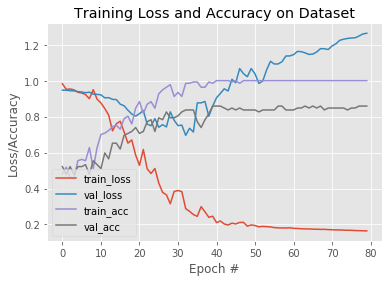

In [6]:
#Results
%matplotlib inline
N = arg_epochs

plt.figure()
plt.style.use("ggplot")
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(args["plot"])



In [0]:
# #(trainX, testX, trainY, testY)
# fig = plt.figure(figsize=(20,20))
# for i in range(6):
#     ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
#     ax.imshow(trainX[i], cmap='gray')
#     ax.set_title(str(trainY[i]))